Importujemy potrzebne biblioteki

In [16]:
import os
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Pobieramy i przetwarzamy dane

In [17]:
# URL do pobrania danych
_URL = "https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/"
_URLS = {
    "train": _URL + "train_150k.txt",
    "test": _URL + "test_62k.txt"
}

# Funkcja przetwarzająca dane
def _define_columns(example):
    text_splited = example["text"].split('\t')
    return {"text": text_splited[1].strip(), "feeling": int(text_splited[0])}

# Pobranie danych
data = datasets.load_dataset("text", data_files=_URLS)

# Przetwarzanie danych
data = data.map(_define_columns)

# Podział na zbiory treningowy, walidacyjny i testowy
texts_dataset_clean = data["train"].train_test_split(train_size=0.8, seed=42)

# Zmiana nazwy zbioru testowego na walidacyjny i przypisanie oryginalnego zbioru testowego
texts_dataset_clean["validation"] = texts_dataset_clean.pop("test")
texts_dataset_clean["test"] = data["test"]

# Ścieżka do zapisu danych w lokalnym folderze roboczym
output_dir = os.getcwd()

# Zapisanie danych do plików JSONL
for split, dataset in texts_dataset_clean.items():
    dataset.to_json(os.path.join(output_dir, f"twitter-sentiment-analysis-{split}.jsonl"))

Creating json from Arrow format: 100%|██████████| 62/62 [00:00<00:00, 435.18ba/s]


Wczytujemy dane z przygotowanych plików JSONL

In [18]:
train_data = pd.read_json("twitter-sentiment-analysis-train.jsonl", lines=True)
val_data = pd.read_json("twitter-sentiment-analysis-validation.jsonl", lines=True)
test_data = pd.read_json("twitter-sentiment-analysis-test.jsonl", lines=True)

X_train, y_train = train_data["text"], train_data["feeling"]
X_val, y_val = val_data["text"], val_data["feeling"]
X_test, y_test = test_data["text"], test_data["feeling"]

Przygotowujemy dane

In [19]:
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

Budujemy i trenujemy model

In [20]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_val_pad, y_val))

Epoch 1/5


c:\Users\harko\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.7214 - loss: 0.5351 - val_accuracy: 0.7885 - val_loss: 0.4504
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - accuracy: 0.8216 - loss: 0.3937 - val_accuracy: 0.7945 - val_loss: 0.4410
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 85ms/step - accuracy: 0.8488 - loss: 0.3383 - val_accuracy: 0.7927 - val_loss: 0.4611
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 80ms/step - accuracy: 0.8689 - loss: 0.2944 - val_accuracy: 0.7864 - val_loss: 0.5059
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 80s 86ms/step - accuracy: 0.8902 - loss: 0.2494 - val_accuracy: 0.7805 - val_loss: 0.5782


Wyświetlamy wykres dokładności modelu

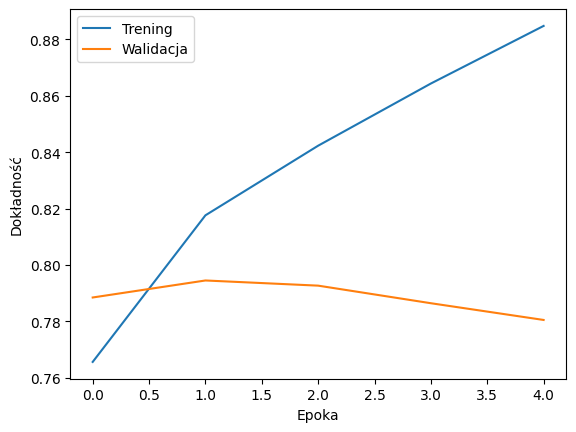

1938/1938 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7824 - loss: 0.5820
Dokładność na zbiorze testowym: 0.78


In [29]:
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Walidacja')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f'Dokładność na zbiorze testowym: {test_acc:.2f}')

Wyświetlamy przykładowe predykcje i rzeczywiste etykiety

In [28]:
print('Przykładowe predykcje:')

random_tweets = np.random.choice(len(X_test_pad), size=8, replace=False)
predictions = model.predict(X_test_pad[random_tweets])
for i, pred in enumerate(predictions):
    actual_label = y_test.iloc[random_tweets[i]] 
    print(f'\n Tweet: {X_test.iloc[i]} \n Predykcja: {"Pozytywna" if pred > 0.5 else "Negatywna"}, Rzeczywista etykieta: {"Pozytywna" if actual_label == 1 else "Negatywna"}')

Przykładowe predykcje:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

 Tweet: @justineville ...yeahhh. ) i'm 39 tweets from 1,600! 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: @ApplesnFeathers aww. Poor baby! On your only REAL day off. 
 Predykcja: Pozytywna, Rzeczywista etykieta: Pozytywna

 Tweet: @joeymcintyre With my refunded $225 (Australian ticket price) I bought me a hot pair of brown boots  Woulda rathered seeing U any day 
 Predykcja: Pozytywna, Rzeczywista etykieta: Pozytywna

 Tweet: It's fine. Today sucks just because me those things. i dunno if i can see you 
 Predykcja: Negatywna, Rzeczywista etykieta: Pozytywna

 Tweet: Im just chilling on psp and stuff, but sitting on pc now, also watching wimledon, getting ready for holiday @WhiteTigerNora Ahh poor you 
 Predykcja: Negatywna, Rzeczywista etykieta: Negatywna

 Tweet: @lisarinna very sad Lisa...she is freeeeeeeeeeee an Angel in Heaven xoxo 
 Predykcja: Pozytywna, Rzeczywista etykieta: Negatywna

 Tweet: Comfo

Usuwamy stworzone pliki JSONL

In [23]:
files_to_delete = [
    "twitter-sentiment-analysis-train.jsonl",
    "twitter-sentiment-analysis-validation.jsonl",
    "twitter-sentiment-analysis-test.jsonl"
]

# Usuwanie plików
for file in files_to_delete:
    if os.path.exists(file):
        os.remove(file)
        print(f"Usunięto plik: {file}")
    else:
        print(f"Plik {file} nie istnieje.")

Usunięto plik: twitter-sentiment-analysis-train.jsonl
Usunięto plik: twitter-sentiment-analysis-validation.jsonl
Usunięto plik: twitter-sentiment-analysis-test.jsonl
